In [116]:
# Importing the libraries
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense , Dropout
import numpy as np
import os

In [113]:
sz = 128
# Building the CNN

classifier = Sequential()

# First convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), input_shape=(sz, sz, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
classifier.add(Flatten())

# building ANN
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.40))
classifier.add(Dense(units=96, activation='relu'))
classifier.add(Dropout(0.40))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=27, activation='softmax')) # softmax for more than 2

# Compiling the final model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # categorical_crossentropy for more than 2
classifier.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 28800)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [114]:
# # Step 2 - Preparing the train/test data and training the model
# Code copied from - https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('Data/train',
                                                 target_size=(sz, sz),
                                                 batch_size=10,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('Data/test',
                                            target_size=(sz , sz),
                                            batch_size=10,
                                            color_mode='grayscale',
                                            class_mode='categorical') 


Found 12845 images belonging to 27 classes.
Found 4268 images belonging to 27 classes.


In [115]:
classifier.fit_generator(
        training_set,
        steps_per_epoch=1285, # No of batches in training set
        epochs=5,
        validation_data=test_set,
        validation_steps=426)# No of batches in test set


C:\Users\PRIYA\AppData\Local\Temp\ipykernel_16988\565905914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  classifier.fit_generator(


Epoch 1/5
  33/1285 [..............................] - ETA: 3:13 - loss: 3.3213 - accuracy: 0.0455

KeyboardInterrupt: 

In [ ]:
# Saving the model
model_json = classifier.to_json()
with open("model-bw.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
classifier.save_weights('model-bw.h5')
print('Weights saved')

Model Saved
Weights saved


In [106]:
from keras.models import model_from_json

# Load the model architecture from the JSON file
with open("model-bw.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights
loaded_model.load_weights("model-bw.h5")

# Compile the loaded model with the desired configuration
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [119]:
import cv2
y_testa=[]
x_testa=[]
image_files = os.listdir('Data/test')
print("Image files found:", len(image_files))
j=0

for i in image_files:
    for img in os.listdir(os.path.join('Data/test',i)):
        # print(img)
        img_pt=os.path.join(os.path.join('Data/test',i),img)
        
        im=cv2.imread(img_pt,cv2.IMREAD_GRAYSCALE)
        im=cv2.resize(im,(sz,sz))
        im=im/255.0
        x_testa.append(im)
        y_testa.append(j)
    j+=1
# x_testa=np.array(x_testa)
x_testa=np.array(x_testa)
y_testa=np.array(y_testa)


predicteda = loaded_model.predict_generator(x_testa, steps=len(x_testa), verbose=1)
predicteda=predicteda.argmax(axis=1)
print(predicteda.shape)

Image files found: 27


C:\Users\PRIYA\AppData\Local\Temp\ipykernel_16988\2542128642.py:24: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicteda = loaded_model.predict_generator(x_testa, steps=len(x_testa), verbose=1)


4268/4268 [==============================] - 49s 11ms/step
(4268,)


In [118]:
predicted = loaded_model.predict_generator(test_set,steps=427,verbose=1)

C:\Users\PRIYA\AppData\Local\Temp\ipykernel_16988\2550637727.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted = loaded_model.predict_generator(test_set,steps=427,verbose=1)


215/427 [==============>...............] - ETA: 8s

KeyboardInterrupt: 

In [128]:
lst = []
ct = 0 
for i in y_testa: 
    lst.append(i)

final_val = predicteda

for i in range(len(lst)):
    if(lst[i]!=final_val[i]) : ct += 1
    
print(ct)
print(len(lst))
   
    

15
4268


In [123]:
print(predicteda)

[ 0  0  0 ... 26 26 26]


In [125]:
predicted_labels = predicteda
true_labels = y_testa


In [126]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)


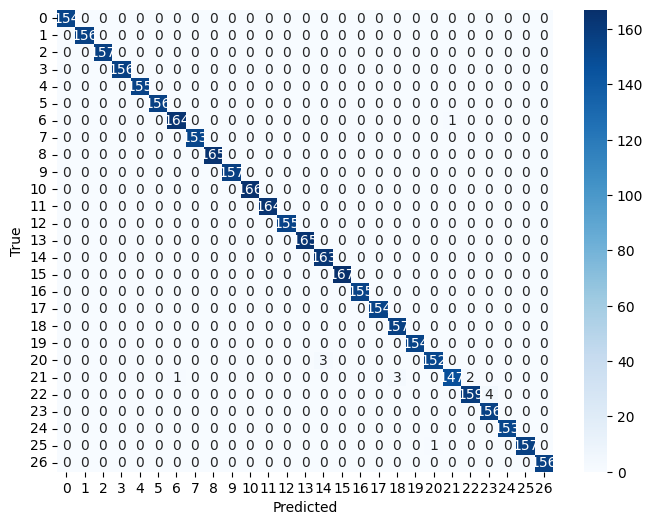

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
